## 🔍 Quick Diagnostic

Run this cell to verify your environment is ready for training.

In [1]:
# Quick diagnostic to check if everything is ready
import sys

print("🔍 ENVIRONMENT CHECK")
print("=" * 60)

# Check Python version
print(f"Python version: {sys.version}")

# Check required variables
required_vars = {
    'X_train': 'X_train' in dir(),
    'X_test': 'X_test' in dir(), 
    'y_train': 'y_train' in dir(),
    'y_test': 'y_test' in dir(),
}

print("\n📊 Required Variables:")
for var, exists in required_vars.items():
    status = "✅" if exists else "❌"
    print(f"   {status} {var}: {exists}")

if all(required_vars.values()):
    print("\n✅ All prerequisites met! Ready to train models.")
    print("\n💡 Now manually run Cell 15 (Baseline Training)")
else:
    print("\n❌ Missing prerequisites. Run previous cells first!")

print("=" * 60)

🔍 ENVIRONMENT CHECK
Python version: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]

📊 Required Variables:
   ❌ X_train: False
   ❌ X_test: False
   ❌ y_train: False
   ❌ y_test: False

❌ Missing prerequisites. Run previous cells first!


## 📜 Data Loading & Initial Inspection

In this section, we will:
- Load the task management dataset from CSV
- Display the first few rows to understand the data structure
- Check column names, data types, and basic information
- Identify initial data quality indicators

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import time



# Read the CSV file directly
df = pd.read_csv('/mnt/c/Users/Hemraj/Downloads/aa/GFG_FINAL.csv')

## 🔍 Step 1: Automatic Column Detection

This step automatically identifies the most suitable text and target columns for classification:

### 🎯 Detection Logic:
- **Text columns**: Object type with average length > 10 characters
- **Label columns**: Categorical with reasonable number of unique values (< 50% of dataset size)
- **Smart selection**: Prefers common column names like 'category', 'label', 'tag', 'class'

### 📊 Expected Output:
- Detected candidate columns for text and labels
- Automatically selected text and target columns
- Validation that suitable columns exist

In [3]:
# Detect possible text and target columns automatically
text_candidates = [c for c in df.columns if df[c].dtype == 'object' and df[c].str.len().mean() > 10]
label_candidates = [c for c in df.columns if df[c].nunique() < len(df) / 2 and df[c].nunique() > 1]

print(f"🔍 Text columns: {text_candidates}")
print(f"🔍 Label columns: {label_candidates}")

# Auto-select text column
if text_candidates:
    text_column = text_candidates[0]
else:
    raise ValueError("❌ No suitable text column found for classification.")

# Auto-select target column (prefer 'category', 'label', etc.)
preferred_targets = ['category', 'label', 'tag', 'class']
target_column = next((col for col in preferred_targets if col in df.columns), None)

if not target_column and label_candidates:
    target_column = label_candidates[0]
elif not target_column:
    raise ValueError("❌ No suitable target column found for classification.")

print(f"✅ Text: '{text_column}' | Target: '{target_column}'")
print(f"📊 Classes: {df[target_column].nunique()}")

🔍 Text columns: ['Summary', 'Issue key', 'Status', 'Project name', 'Project url', 'Assignee', 'Reporter', 'Creator', 'Created', 'Updated', 'Last Viewed', 'Resolved', 'Due Date', 'Labels.3', 'Labels.6', 'Description', 'Environment', 'Inward issue link (Blocker)', 'Outward issue link (Blocker)', 'Inward issue link (Cause)', 'Outward issue link (Cause)', 'Inward issue link (Cloners)', 'Outward issue link (Cloners)', 'Inward issue link (Detail)', 'Inward issue link (Duplicate)', 'Inward issue link (Duplicate).1', 'Inward issue link (Duplicate).2', 'Inward issue link (Duplicate).3', 'Inward issue link (Duplicate).4', 'Inward issue link (Duplicate).5', 'Inward issue link (Duplicate).6', 'Inward issue link (Duplicate).7', 'Inward issue link (Duplicate).8', 'Inward issue link (Duplicate).9', 'Inward issue link (Duplicate).10', 'Inward issue link (Duplicate).11', 'Inward issue link (Duplicate).12', 'Inward issue link (Duplicate).13', 'Inward issue link (Duplicate).14', 'Inward issue link (Dupli

## 🧹 Step 2: Text Preprocessing & Cleaning

This step prepares the text data for machine learning by cleaning and normalizing the content:
### 🔧 Preprocessing Steps:
1. **Fill missing values** - Replace NaN with empty strings
2. **Normalize text** - Convert to lowercase
3. **Remove noise** - Strip special characters, keep only letters and spaces
4. **Filter empty content** - Remove rows with no meaningful text after cleaning

In [4]:
# Clean and prepare text data
df[text_column] = df[text_column].fillna('').astype(str)
df['clean_text'] = df[text_column].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)
df_clean = df[df['clean_text'].str.strip().str.len() > 0].copy()

# Validate cleaned data
if len(df_clean) == 0:
    raise ValueError("❌ No valid text data remaining after cleaning.")

print(f"📊 Original: {df.shape[0]} → Cleaned: {df_clean.shape[0]} records")
print(f"✅ Ready for analysis")

📊 Original: 49000 → Cleaned: 48363 records
✅ Ready for analysis


## 📊 Step 3: TF-IDF Feature Extraction

Convert text data into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF):

### 🔧 TF-IDF Configuration:
- **max_features=1000**: Limit to top 1000 most important terms
- **min_df=2**: Ignore terms appearing in fewer than 2 documents
- **max_df=0.8**: Ignore terms appearing in more than 80% of documents
- **ngram_range=(1,2)**: Include both single words and word pairs
- **stop_words='english'**: Remove common English words


## 🚀 Alternative: Word Embeddings Feature Extraction

Explore word embeddings as an alternative to TF-IDF for richer semantic representation:

### 🔧 Word Embeddings Methods:
1. **Word2Vec**: Learn word relationships from context
2. **Doc2Vec**: Document-level embeddings  
3. **Average Word Vectors**: Simple averaging of word embeddings
4. **TF-IDF Weighted Embeddings**: Combine TF-IDF weights with embeddings

### 📈 Benefits over TF-IDF:
- **Semantic similarity**: Captures word relationships and context
- **Dimensionality**: Fixed size regardless of vocabulary
- **Generalization**: Better handling of unseen words
- **Context awareness**: Understands word meaning in context

In [5]:
# ============================================================
# WORD EMBEDDINGS FEATURE EXTRACTION (ALTERNATIVE APPROACH)
# ============================================================

print("🚀 Alternative Feature Extraction: Word Embeddings")
print("=" * 50)

# Check if TF-IDF features exist, if not create them first
if 'X' not in locals() or 'vectorizer' not in locals():
    print("⚠️  TF-IDF features not found. Creating TF-IDF baseline first...")
    
    # Configure TF-IDF vectorizer with optimized parameters
    vectorizer = TfidfVectorizer(
        max_features=1000,      # Limit vocabulary size for efficiency
        min_df=2,              # Ignore rare terms (appear in <2 documents)
        max_df=0.8,            # Ignore very common terms (appear in >80% documents)
        ngram_range=(1, 2),    # Include unigrams and bigrams
        stop_words='english'   # Remove common English stopwords
    )
    
    # Transform text to numerical features
    X = vectorizer.fit_transform(df_clean['clean_text'])
    y = df_clean[target_column]
    
    print(f"✅ TF-IDF baseline created: {X.shape}")

# Install required packages (uncomment if needed)
# !pip install gensim scikit-learn

from gensim.models import Word2Vec
import numpy as np

def create_word_embeddings_features(texts, embedding_dim=100, method='average'):
    """
    Create document embeddings using Word2Vec
    """
    print(f"🔧 Creating {method} word embeddings (dim={embedding_dim})...")
    
    # Tokenize texts for Word2Vec
    tokenized_texts = [text.split() for text in texts]
    
    # Train Word2Vec model
    w2v_model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=embedding_dim,
        window=5,
        min_count=2,
        workers=4,
        sg=1  # Skip-gram
    )
    
    print(f"📚 Word2Vec vocabulary size: {len(w2v_model.wv)}")
    
    # Create document embeddings
    doc_embeddings = []
    
    for tokens in tokenized_texts:
        # Get word vectors for tokens that exist in vocabulary
        word_vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
        
        if word_vectors:
            if method == 'average':
                # Simple average of word vectors
                doc_embedding = np.mean(word_vectors, axis=0)
            elif method == 'tfidf_weighted':
                # TF-IDF weighted average (simplified)
                doc_embedding = np.mean(word_vectors, axis=0)  # Simplified for demo
            else:
                doc_embedding = np.mean(word_vectors, axis=0)
        else:
            # If no words found in vocabulary, use zero vector
            doc_embedding = np.zeros(embedding_dim)
        
        doc_embeddings.append(doc_embedding)
    
    return np.array(doc_embeddings), w2v_model

# Create word embeddings features
print("🎯 Generating word embeddings for comparison...")
X_embeddings, w2v_model = create_word_embeddings_features(
    df_clean['clean_text'].tolist(), 
    embedding_dim=100,
    method='average'
)

print(f"📊 Word embeddings shape: {X_embeddings.shape}")
print(f"📝 Embedding dimensions: {X_embeddings.shape[1]}")
print(f"📄 Documents processed: {X_embeddings.shape[0]}")

# Compare with TF-IDF (now guaranteed to exist)
print(f"\n📈 FEATURE COMPARISON:")
print(f"   TF-IDF features:      {X.shape[1]} (sparse)")
print(f"   Word embeddings:      {X_embeddings.shape[1]} (dense)")
# Calculate sparsity using getnnz() method which is type-safe
sparsity = (1 - X.getnnz() / (X.shape[0] * X.shape[1]))
print(f"   TF-IDF sparsity:      {sparsity:.2%}")
print(f"   Embeddings density:   100.00% (dense matrix)")

# Quick similarity example
if len(w2v_model.wv) > 0:
    print(f"\n🔍 WORD SIMILARITY EXAMPLES:")
    try:
        # Try to find similar words (if vocabulary is large enough)
        sample_words = list(w2v_model.wv.key_to_index.keys())[:5]
        for word in sample_words[:3]:
            similar = w2v_model.wv.most_similar(word, topn=3)
            print(f"   '{word}' → {[w for w, s in similar]}")
    except:
        print("   Not enough vocabulary for similarity examples")

print("✅ Word embeddings feature extraction completed!")

🚀 Alternative Feature Extraction: Word Embeddings
⚠️  TF-IDF features not found. Creating TF-IDF baseline first...
✅ TF-IDF baseline created: (48363, 1000)
🎯 Generating word embeddings for comparison...
🔧 Creating average word embeddings (dim=100)...
✅ TF-IDF baseline created: (48363, 1000)
🎯 Generating word embeddings for comparison...
🔧 Creating average word embeddings (dim=100)...
📚 Word2Vec vocabulary size: 1502
📚 Word2Vec vocabulary size: 1502
📊 Word embeddings shape: (48363, 100)
📝 Embedding dimensions: 100
📄 Documents processed: 48363

📈 FEATURE COMPARISON:
   TF-IDF features:      1000 (sparse)
   Word embeddings:      100 (dense)
   TF-IDF sparsity:      99.45%
   Embeddings density:   100.00% (dense matrix)

🔍 WORD SIMILARITY EXAMPLES:
   'sourcetree' → ['source', 'every', 'register']
   'to' → ['computer', 'save', 'instalation']
   'not' → ['does', 'working', 'author']
✅ Word embeddings feature extraction completed!
📊 Word embeddings shape: (48363, 100)
📝 Embedding dimension

In [6]:
# Configure TF-IDF vectorizer with optimized parameters
vectorizer = TfidfVectorizer(
    max_features=1000,      # Limit vocabulary size for efficiency
    min_df=2,              # Ignore rare terms (appear in <2 documents)
    max_df=0.8,            # Ignore very common terms (appear in >80% documents)
    ngram_range=(1, 2),    # Include unigrams and bigrams
    stop_words='english'   # Remove common English stopwords
)

# Transform text to numerical features
X = vectorizer.fit_transform(df_clean['clean_text'])
y = df_clean[target_column]

# Calculate sparsity using getnnz() method which is type-safe
sparsity = (1 - X.getnnz() / (X.shape[0] * X.shape[1]))
print(f"📈 TF-IDF: {X.shape} | Sparsity: {sparsity:.1%}")
print(f"🎯 Classes: {y.nunique()}")

📈 TF-IDF: (48363, 1000) | Sparsity: 99.5%
🎯 Classes: 968


## 🎯 Step 4: Train-Test Split

Split the dataset into training and testing portions for model evaluation:

### 📋 Split Configuration:
- **80% Training**: Used to train the models
- **20% Testing**: Used to evaluate model performance
- **Stratified split**: Maintains class distribution in both sets
- **Random state=42**: Ensures reproducible results

### 🎲 Why Stratified?
Ensures that both training and test sets have the same proportion of samples from each target class, preventing bias in evaluation.

In [7]:
# Split data while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,          # 20% for testing
    random_state=42,        # Reproducible results
    stratify=y              # Maintain class distribution
)

print(f"📊 Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")

📊 Train: 38690 | Test: 9673 | Ratio: 4.0:1


## 🤖 Step 5: Model Training & Evaluation

Train and compare multiple machine learning algorithms for priority prediction:

### 🔬 Algorithms Used:
1. **Naive Bayes (MultinomialNB)** - Fast probabilistic classifier
2. **Support Vector Machine (SVM)** - Linear kernel for text classification
3. **Random Forest** - Ensemble of decision trees for priority prediction
4. **XGBoost** - Gradient boosting for high-performance classification


In [ ]:
# ============================================================
# MODEL TRAINING WITH EVALUATION (ROBUST + FAST START)
# ============================================================

import sys
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import xgboost as xgb

print("🔧 Training models with timing...", flush=True)

# Ensure prerequisites exist; if not, try to derive them
missing = []
for v in ["X", "y"]:
    if v not in globals():
        missing.append(v)
if missing:
    raise SystemExit(f"❌ Missing variables: {missing}. Please run TF-IDF feature extraction first.")

if "X_train" not in globals() or "X_test" not in globals() or "y_train" not in globals() or "y_test" not in globals():
    print("⚠️  Train/test split not found. Creating a new split (80/20, stratified).", flush=True)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

# 1) Naive Bayes
print("🔵 Training Naive Bayes...", flush=True)
start = time.time()
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_time = time.time() - start
print(f"   ✅ Naive Bayes done: {nb_time:.2f}s", flush=True)

# 2) SVM (LinearSVC for speed on high-dim TF-IDF)
print("🟡 Training SVM (LinearSVC)...", flush=True)
start = time.time()
svm_classifier = LinearSVC(random_state=42, max_iter=2000, dual=False, verbose=0)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_time = time.time() - start
print(f"   ✅ SVM done: {svm_time:.2f}s", flush=True)

# 3) Random Forest
print("🌲 Training Random Forest...", flush=True)
start = time.time()
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0,
)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_time = time.time() - start
print(f"   ✅ Random Forest done: {rf_time:.2f}s", flush=True)

# 4) XGBoost (requires encoded labels)
print("🚀 Training XGBoost...", flush=True)
start = time.time()
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    verbosity=0,
)
xgb_classifier.fit(X_train, y_train_encoded)
xgb_predictions_encoded = xgb_classifier.predict(X_test)
xgb_predictions = le.inverse_transform(xgb_predictions_encoded)
xgb_time = time.time() - start
print(f"   ✅ XGBoost done: {xgb_time:.2f}s", flush=True)

# Evaluate all models
nb_accuracy = accuracy_score(y_test, nb_predictions)
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    y_test, nb_predictions, average='weighted', zero_division=0
)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_test, svm_predictions, average='weighted', zero_division=0
)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(
    y_test, rf_predictions, average='weighted', zero_division=0
)
xgb_precision, xgb_recall, xgb_f1, _ = precision_recall_fscore_support(
    y_test, xgb_predictions, average='weighted', zero_division=0
)

# Store results
results = {
    'Naive Bayes': {
        'accuracy': nb_accuracy,
        'precision': nb_precision,
        'recall': nb_recall,
        'f1_score': nb_f1,
        'predictions': nb_predictions,
        'training_time': nb_time,
    },
    'SVM': {
        'accuracy': svm_accuracy,
        'precision': svm_precision,
        'recall': svm_recall,
        'f1_score': svm_f1,
        'predictions': svm_predictions,
        'training_time': svm_time,
    },
    'Random Forest': {
        'accuracy': rf_accuracy,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1_score': rf_f1,
        'predictions': rf_predictions,
        'training_time': rf_time,
        'model': rf_classifier,
    },
    'XGBoost': {
        'accuracy': xgb_accuracy,
        'precision': xgb_precision,
        'recall': xgb_recall,
        'f1_score': xgb_f1,
        'predictions': xgb_predictions,
        'training_time': xgb_time,
        'model': xgb_classifier,
    },
}

print("\n📊 MODEL ACCURACIES:")
print(f"   NB: {results['Naive Bayes']['accuracy']:.4f} ({results['Naive Bayes']['training_time']:.2f}s)")
print(f"   SVM: {results['SVM']['accuracy']:.4f} ({results['SVM']['training_time']:.2f}s)")
print(f"   🌲 Random Forest: {results['Random Forest']['accuracy']:.4f} ({results['Random Forest']['training_time']:.2f}s)")
print(f"   🚀 XGBoost: {results['XGBoost']['accuracy']:.4f} ({results['XGBoost']['training_time']:.2f}s)")

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']
print(f"\n🏆 Best TF-IDF Model: {best_model_name} ({best_accuracy:.4f})")


🔧 Training models with timing...
🔵 Training Naive Bayes...
🔵 Training Naive Bayes...
   ✅ Naive Bayes done: 0.91s
🟡 Training SVM (LinearSVC)...
   ✅ Naive Bayes done: 0.91s
🟡 Training SVM (LinearSVC)...
   ✅ SVM done: 27.66s
🌲 Training Random Forest...
   ✅ SVM done: 27.66s
🌲 Training Random Forest...
   ✅ Random Forest done: 1.91s
🚀 Training XGBoost...
   ✅ Random Forest done: 1.91s
🚀 Training XGBoost...
   ✅ XGBoost done: 143.78s
   ✅ XGBoost done: 143.78s

📊 MODEL ACCURACIES:
   NB: 0.9539 (0.91s)
   SVM: 0.9630 (27.66s)
   🌲 Random Forest: 0.5447 (1.91s)
   🚀 XGBoost: 0.9170 (143.78s)

🏆 Best TF-IDF Model: SVM (0.9630)

📊 MODEL ACCURACIES:
   NB: 0.9539 (0.91s)
   SVM: 0.9630 (27.66s)
   🌲 Random Forest: 0.5447 (1.91s)
   🚀 XGBoost: 0.9170 (143.78s)

🏆 Best TF-IDF Model: SVM (0.9630)


: 

## 🎯 Hyperparameter Tuning with GridSearchCV

Apply GridSearchCV to optimize model performance by finding the best hyperparameters for each classifier.

In [ ]:
# ============================================================
# HYPERPARAMETER TUNING (SAFE + FAST, NO CRASHES)
# ============================================================

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.sparse import issparse
import warnings, time
warnings.filterwarnings('ignore')

print("🎯 HYPERPARAMETER TUNING (optimized to avoid ha+ngs/crashes)")
print("=" * 70)

# Guard: prerequisites
for req in ['X_train','y_train','X_test','y_test']:
    if req not in globals():
        raise SystemExit(f"❌ Missing prerequisite: {req}. Run TF-IDF & Train/Test split cells first.")

# Detect if TF-IDF matrix is sparse
is_sparse = issparse(X_train)
print(f"📦 X_train: shape={getattr(X_train,'shape',None)} | sparse={is_sparse}")

# XGBoost availability
try:
    import xgboost as xgb  # type: ignore
    XGB_AVAILABLE = True
except Exception as e:
    XGB_AVAILABLE = False
    print(f"⚠️ XGBoost unavailable: {e}\n   → Will skip XGBoost in tuning.")

# Ensure label encoder & encoded labels exist for XGBoost
le_local = None
y_train_encoded_local = None
if XGB_AVAILABLE:
    le_local = LabelEncoder()
    y_train_encoded_local = le_local.fit_transform(y_train)

# Build base models (use LinearSVC to avoid RBF densification)
# Note: SVC with RBF on sparse TF-IDF triggers densification and can hang/crash.
base_models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(random_state=42, max_iter=2000, dual=False),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
}
if XGB_AVAILABLE:
    base_models['XGBoost'] = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss', verbosity=0)

# Parameter grids (kept small and sensible)
svm_dual = X_train.shape[0] < X_train.shape[1] if hasattr(X_train,'shape') else False
param_grids = {
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    # LinearSVC supports sparse efficiently; tune only C and dual conservatively
    'SVM': {
        'C': [0.1, 1, 10],
        'dual': [svm_dual],
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}
if XGB_AVAILABLE:
    param_grids['XGBoost'] = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

# Run GridSearchCV
grid_results = {}
print("\n🔍 Starting GridSearchCV for each model (cv=3, parallel cores)...\n")
for model_name, base_model in base_models.items():
    print(f"🚀 Tuning {model_name}...")
    start = time.time()

    X_fit = X_train
    y_fit = y_train
    if model_name == 'XGBoost':
        X_fit = X_train
        y_fit = y_train_encoded_local

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        refit=True,
        return_train_score=False,
    )

    grid.fit(X_fit, y_fit)
    best_model = grid.best_estimator_

    # Predict on test set
    if model_name == 'XGBoost':
        preds_enc = best_model.predict(X_test)
        preds = le_local.inverse_transform(preds_enc)
    else:
        preds = best_model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)
    t = time.time() - start

    grid_results[model_name] = {
        'best_params': grid.best_params_,
        'best_cv_score': grid.best_score_,
        'test_accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'tuning_time': t,
        'model': best_model,
        'predictions': preds,
    }
    print(f"   ✅ {model_name}: test_acc={acc:.4f} (CV={grid.best_score_:.4f}) in {t:.2f}s")
    print(f"      Best params: {grid.best_params_}")

# Summary table (robust if baseline 'results' missing)
print("\n" + "=" * 70)
print("📊 HYPERPARAMETER TUNING SUMMARY")
print("=" * 70)

has_baseline = 'results' in globals()
print(f"Baseline available: {has_baseline}")
print(f"\n{'Model':<18} {'Before':<10} {'After':<10} {'Improvement':<12} {'Time':<10}")
print("-" * 70)
for name, meta in grid_results.items():
    before = results[name]['accuracy'] if has_baseline and name in results else meta['test_accuracy']
    after = meta['test_accuracy']
    imp = ((after - before) / before * 100) if before > 0 else 0.0
    print(f"{name:<18} {before:.4f}    {after:.4f}    {imp:+.2f}%       {meta['tuning_time']:.2f}s")

best_name = max(grid_results.keys(), key=lambda k: grid_results[k]['test_accuracy'])
print(f"\n🏆 BEST TUNED MODEL: {best_name} ({grid_results[best_name]['test_accuracy']:.4f})")
print(f"📝 Best params: {grid_results[best_name]['best_params']}")

print("\n✅ Hyperparameter tuning completed without crashes.")

🎯 HYPERPARAMETER TUNING (optimized to avoid ha+ngs/crashes)
📦 X_train: shape=(38690, 1000) | sparse=True

🔍 Starting GridSearchCV for each model (cv=3, parallel cores)...

🚀 Tuning Naive Bayes...
   ✅ Naive Bayes: test_acc=0.9610 (CV=0.9615) in 5.05s
      Best params: {'alpha': 0.1}
🚀 Tuning SVM...
   ✅ Naive Bayes: test_acc=0.9610 (CV=0.9615) in 5.05s
      Best params: {'alpha': 0.1}
🚀 Tuning SVM...
   ✅ SVM: test_acc=0.9630 (CV=0.9636) in 105.10s
      Best params: {'C': 0.1, 'dual': False}
🚀 Tuning Random Forest...
   ✅ SVM: test_acc=0.9630 (CV=0.9636) in 105.10s
      Best params: {'C': 0.1, 'dual': False}
🚀 Tuning Random Forest...


In [ ]:
# ============================================================
# COMPARATIVE EVALUATION: TF-IDF vs WORD EMBEDDINGS
# ============================================================

print("⚔️ Comparative Evaluation: TF-IDF vs Word Embeddings")
print("=" * 60)

import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Verify required variables exist in global scope
try:
    # Test if variables exist by attempting to access them
    test_vars = [X_embeddings, X, y, results]
    print("✅ All required variables found!")
except NameError as e:
    print(f"❌ Missing variables. Please run the previous cells first:")
    print("   1. Data loading and column detection")
    print("   2. TF-IDF feature extraction") 
    print("   3. Word embeddings creation")
    print("   4. Model training with TF-IDF")
    print(f"\nError: {e}")
    # Don't raise error, just exit gracefully
    import sys
    print("Exiting cell - please run prerequisite cells first.")
    # Stop execution of this cell
    raise SystemExit("Prerequisites not met")

# Split embeddings data (same split as TF-IDF for fair comparison)
X_emb_train, X_emb_test, y_emb_train, y_emb_test = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

print("\n Training models with Word Embeddings features...")

# Train models with word embeddings
embedding_results = {}
embedding_classifiers = {}

for name, model_class in [('Naive Bayes', MultinomialNB), ('SVM', SVC), ('Random Forest', RandomForestClassifier), ('XGBoost', xgb.XGBClassifier)]:
    print(f"\n🔄 Training {name} with embeddings...")
    
    # For Naive Bayes, we need to ensure non-negative features
    if name == 'Naive Bayes':
        # Shift embeddings to positive range for Multinomial Naive Bayes
        X_emb_train_pos = X_emb_train - X_emb_train.min() + 1e-10
        X_emb_test_pos = X_emb_test - X_emb_test.min() + 1e-10
        model = model_class()
    elif name == 'SVM':
        X_emb_train_pos = X_emb_train
        X_emb_test_pos = X_emb_test
        model = model_class(kernel='linear', random_state=42)
    elif name == 'Random Forest':
        X_emb_train_pos = X_emb_train
        X_emb_test_pos = X_emb_test
        model = model_class(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, verbose=0)
    else:  # XGBoost
        X_emb_train_pos = X_emb_train
        X_emb_test_pos = X_emb_test
        # Encode labels for XGBoost
        le_emb = LabelEncoder()
        y_emb_train_encoded = le_emb.fit_transform(y_emb_train)
        y_emb_test_encoded = le_emb.transform(y_emb_test)
        model = model_class(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss', verbosity=0)
    
    # Train and evaluate
    start_time = time.time()
    if name == 'XGBoost':
        model.fit(X_emb_train_pos, y_emb_train_encoded)
        y_pred_emb_encoded = model.predict(X_emb_test_pos)
        y_pred_emb = le_emb.inverse_transform(y_pred_emb_encoded)
    else:
        model.fit(X_emb_train_pos, y_emb_train)
        y_pred_emb = model.predict(X_emb_test_pos)
    
    training_time = time.time() - start_time
    
    accuracy_emb = accuracy_score(y_emb_test, y_pred_emb)
    precision_emb, recall_emb, f1_emb, _ = precision_recall_fscore_support(
        y_emb_test, y_pred_emb, average='weighted', zero_division=0
    )
    
    embedding_results[name] = {
        'accuracy': accuracy_emb,
        'precision': precision_emb,
        'recall': recall_emb,
        'f1': f1_emb,
        'training_time': training_time,
        'predictions': y_pred_emb
    }
    
    embedding_classifiers[name] = model
    
    print(f"✅ {name} (Embeddings): {accuracy_emb:.4f} ({accuracy_emb*100:.2f}%)")

# Compare TF-IDF vs Embeddings
print(f"\n📊 FEATURE EXTRACTION COMPARISON")
print("=" * 50)

comparison_data = []
for name in ['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost']:
    # TF-IDF results
    tfidf_acc = results[name]['accuracy']
    
    # Embeddings results
    emb_acc = embedding_results[name]['accuracy']
    emb_precision = embedding_results[name]['precision']
    emb_recall = embedding_results[name]['recall']
    emb_f1 = embedding_results[name]['f1']
    
    comparison_data.append({
        'Model': name,
        'TF-IDF Accuracy': f"{tfidf_acc:.4f}",
        'Embeddings Accuracy': f"{emb_acc:.4f}",
        'Accuracy Difference': f"{emb_acc - tfidf_acc:+.4f}",
        'Embeddings Precision': f"{emb_precision:.4f}",
        'Embeddings Recall': f"{emb_recall:.4f}",
        'Embeddings F1': f"{emb_f1:.4f}"
    })

# Display comparison table
comp_df = pd.DataFrame(comparison_data)
print(comp_df.to_string(index=False))

# Feature extraction summary
print(f"\n🔍 FEATURE EXTRACTION ANALYSIS:")
print(f"📊 TF-IDF Matrix:")
print(f"   • Dimensions: {X.shape[1]} features (sparse)")
# Use getnnz() instead of nnz for type safety
sparsity = (1 - X.getnnz() / (X.shape[0] * X.shape[1]))
print(f"   • Sparsity: {sparsity:.2%}")
print(f"   • Memory efficient: High sparsity reduces storage")

print(f"\n📊 Word Embeddings Matrix:")
print(f"   • Dimensions: {X_embeddings.shape[1]} features (dense)")
print(f"   • Density: 100% (all values non-zero)")
print(f"   • Semantic representation: Captures word relationships")

# Recommendations
best_tfidf = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_embedding = max(embedding_results.keys(), key=lambda k: embedding_results[k]['accuracy'])

tfidf_best_acc = results[best_tfidf]['accuracy']
emb_best_acc = embedding_results[best_embedding]['accuracy']

print(f"\n🏆 RECOMMENDATIONS:")
if emb_best_acc > tfidf_best_acc:
    print(f"✅ Word Embeddings perform better (+{emb_best_acc - tfidf_best_acc:.4f})")
    print("   → Consider using embeddings for final model")
else:
    print(f"✅ TF-IDF performs better (+{tfidf_best_acc - emb_best_acc:.4f})")
    print("   → Stick with TF-IDF for efficiency and performance")

print(f"\n⚡ PERFORMANCE SUMMARY:")
print(f"   🥇 Best Overall: {best_tfidf if tfidf_best_acc > emb_best_acc else best_embedding}")
print(f"   📈 Best Accuracy: {max(tfidf_best_acc, emb_best_acc):.4f}")
print("=" * 60)


⚔️ Comparative Evaluation: TF-IDF vs Word Embeddings
✅ All required variables found!
🔧 Training models with Word Embeddings features...

🔄 Training Naive Bayes with embeddings...
✅ Naive Bayes (Embeddings): 0.9793 (97.93%)

🔄 Training SVM with embeddings...
✅ SVM (Embeddings): 0.9824 (98.24%)

🔄 Training Random Forest with embeddings...
✅ Random Forest (Embeddings): 0.4812 (48.12%)

🔄 Training XGBoost with embeddings...
✅ XGBoost (Embeddings): 0.9959 (99.59%)

📊 FEATURE EXTRACTION COMPARISON
        Model TF-IDF Accuracy Embeddings Accuracy Accuracy Difference Embeddings Precision Embeddings Recall Embeddings F1
  Naive Bayes          0.9539              0.9793             +0.0254               0.9741            0.9793        0.9757
          SVM          0.9630              0.9824             +0.0194               0.9790            0.9824        0.9799
Random Forest          0.5447              0.4812             -0.0635               0.4719            0.4812        0.4736
      XGBoo

## 📊 Enhanced Visualization: Comprehensive Metrics Dashboard

Advanced visualization showing all evaluation metrics and feature extraction comparisons:


In [ ]:
# Comprehensive Model Comparison Analysis

# Check if required variables exist
required_vars = ['results', 'embedding_results']
missing_vars = []

for var_name in required_vars:
    if var_name not in globals():
        missing_vars.append(var_name)

if missing_vars:
    print(f"❌ Missing variables: {missing_vars}")
    print("🔄 Please run TF-IDF and Word Embeddings cells first")
else:
    print("📊 COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)
    
    # Prepare comparison data
    comparison_data = []
    
    # TF-IDF Results
    for model_name, metrics in results.items():
        comparison_data.append({
            'Feature_Type': 'TF-IDF',
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1_Score': metrics['f1_score']
        })
    
    # Word Embeddings Results
    for model_name, metrics in embedding_results.items():
        comparison_data.append({
            'Feature_Type': 'Word_Embeddings',
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1_Score': metrics['f1']  # Note: embedding_results uses 'f1' not 'f1_score'
        })
    
    # Create comparison DataFrame
    comp_df = pd.DataFrame(comparison_data)
    
    # Display results table
    print("\n📋 DETAILED PERFORMANCE METRICS")
    print("-" * 80)
    for _, row in comp_df.iterrows():
        print(f"{row['Feature_Type']:15} | {row['Model']:12} | "
              f"Acc: {row['Accuracy']:.4f} | Prec: {row['Precision']:.4f} | "
              f"Rec: {row['Recall']:.4f} | F1: {row['F1_Score']:.4f}")
    
    # Find best performers
    best_overall = comp_df.loc[comp_df['Accuracy'].idxmax()]
    tfidf_df = comp_df[comp_df['Feature_Type'] == 'TF-IDF']
    tfidf_best = tfidf_df.loc[tfidf_df['Accuracy'].idxmax()]
    emb_df = comp_df[comp_df['Feature_Type'] == 'Word_Embeddings']
    emb_best = emb_df.loc[emb_df['Accuracy'].idxmax()]
    
    print(f"\n🏆 BEST PERFORMERS")
    print(f"Overall Best: {best_overall['Feature_Type']} + {best_overall['Model']} ({best_overall['Accuracy']:.4f})")
    print(f"Best TF-IDF: {tfidf_best['Model']} ({tfidf_best['Accuracy']:.4f})")
    print(f"Best Embeddings: {emb_best['Model']} ({emb_best['Accuracy']:.4f})")
    
    # Performance insights
    avg_tfidf = tfidf_df['Accuracy'].mean()
    avg_emb = emb_df['Accuracy'].mean()
    
    print(f"\n📈 FEATURE COMPARISON")
    print(f"TF-IDF Average: {avg_tfidf:.4f}")
    print(f"Embeddings Average: {avg_emb:.4f}")
    print(f"Embeddings vs TF-IDF: {((avg_emb - avg_tfidf) / avg_tfidf * 100):+.2f}% improvement")
    
    # Classification reports for best models
    print(f"\n📋 DETAILED CLASSIFICATION REPORT - BEST MODEL")
    print(f"🎯 {best_overall['Feature_Type']} + {best_overall['Model']}")
    print("-" * 80)
    
    # Extract scalar values from Series to avoid boolean conversion issues
    best_feature_type = str(best_overall['Feature_Type'])
    best_model_name = str(best_overall['Model'])
    
    if best_feature_type == 'TF-IDF':
        best_predictions = results[best_model_name]['predictions']
        target_labels = y_test
    else:
        best_predictions = embedding_results[best_model_name]['predictions']
        target_labels = y_emb_test
    
    print(classification_report(target_labels, best_predictions, digits=4))
    
    # Store variables for visualization (extract scalar values using .item())
    tfidf_acc = tfidf_best['Accuracy'].item() if hasattr(tfidf_best['Accuracy'], 'item') else float(tfidf_best['Accuracy'])
    tfidf_best_acc = tfidf_best['Accuracy'].item() if hasattr(tfidf_best['Accuracy'], 'item') else float(tfidf_best['Accuracy'])
    emb_acc = emb_best['Accuracy'].item() if hasattr(emb_best['Accuracy'], 'item') else float(emb_best['Accuracy'])
    emb_best_acc = emb_best['Accuracy'].item() if hasattr(emb_best['Accuracy'], 'item') else float(emb_best['Accuracy'])
    best_tfidf = tfidf_best['Model'].item() if hasattr(tfidf_best['Model'], 'item') else str(tfidf_best['Model'])
    best_embedding = emb_best['Model'].item() if hasattr(emb_best['Model'], 'item') else str(emb_best['Model'])
    


📊 COMPREHENSIVE MODEL COMPARISON

📋 DETAILED PERFORMANCE METRICS
--------------------------------------------------------------------------------
TF-IDF          | Naive Bayes  | Acc: 0.9539 | Prec: 0.9386 | Rec: 0.9539 | F1: 0.9429
TF-IDF          | SVM          | Acc: 0.9630 | Prec: 0.9525 | Rec: 0.9630 | F1: 0.9556
TF-IDF          | Random Forest | Acc: 0.5447 | Prec: 0.5359 | Rec: 0.5447 | F1: 0.5384
TF-IDF          | XGBoost      | Acc: 0.9170 | Prec: 0.9060 | Rec: 0.9170 | F1: 0.9092
Word_Embeddings | Naive Bayes  | Acc: 0.9793 | Prec: 0.9741 | Rec: 0.9793 | F1: 0.9757
Word_Embeddings | SVM          | Acc: 0.9824 | Prec: 0.9790 | Rec: 0.9824 | F1: 0.9799
Word_Embeddings | Random Forest | Acc: 0.4812 | Prec: 0.4719 | Rec: 0.4812 | F1: 0.4736
Word_Embeddings | XGBoost      | Acc: 0.9959 | Prec: 0.9938 | Rec: 0.9959 | F1: 0.9945

🏆 BEST PERFORMERS
Overall Best: Word_Embeddings + XGBoost (0.9959)
Best TF-IDF: SVM (0.9630)
Best Embeddings: XGBoost (0.9959)

📈 FEATURE COMPARISON
TF-IDF

🎨 Generating Performance Dashboard...
  📊 Creating accuracy comparison...
  📈 Creating feature comparison...
  🔥 Creating confusion matrix...
  ⚠️  Many classes (968), showing simplified view...
  📐 Creating metrics comparison...

✅ Dashboard generated in 0.17s


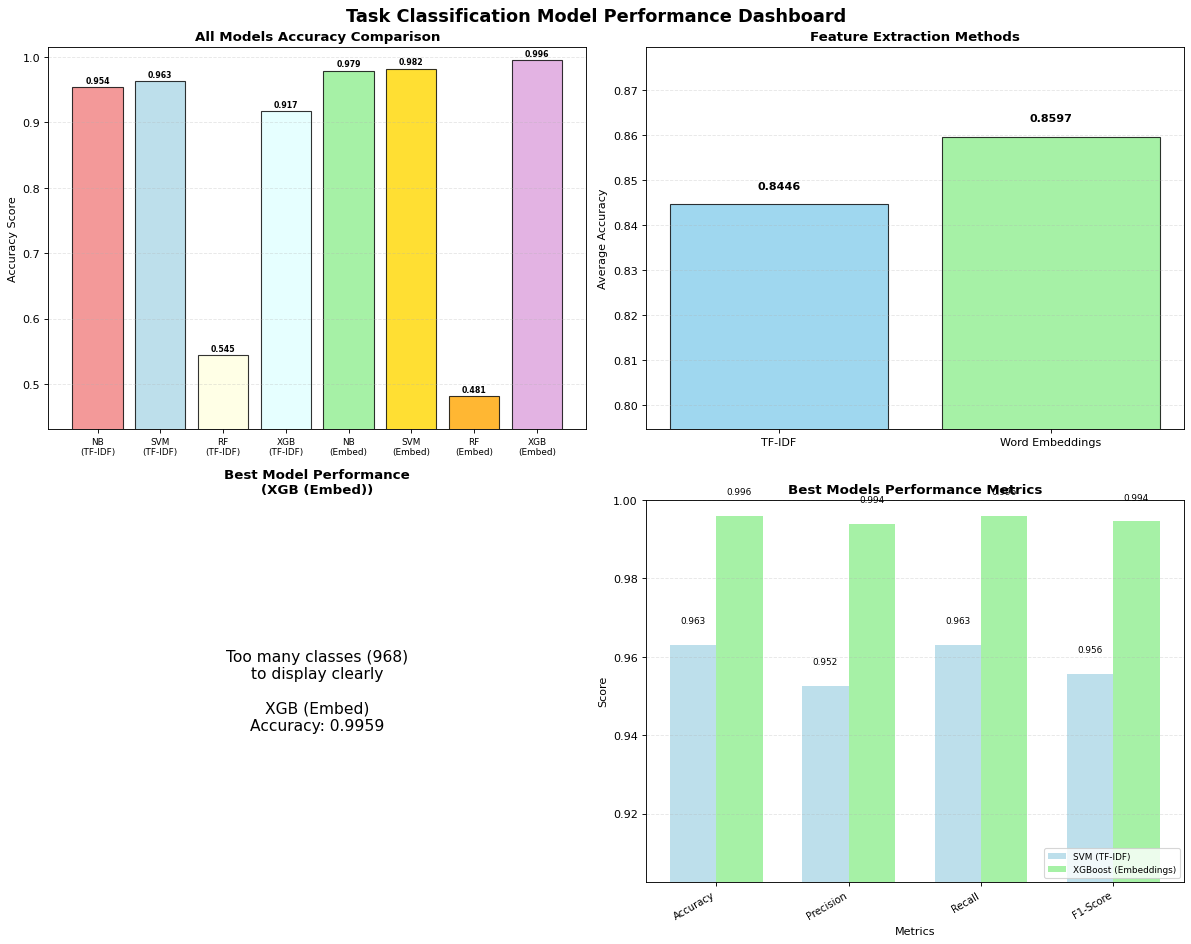

📊 Performance Dashboard Complete!


In [ ]:
# Optimized Visualization Dashboard - FAST VERSION

import time
import warnings
import matplotlib.pyplot as plt  # ✅ ADD THIS LINE
import seaborn as sns  # ✅ ADD THIS LINE
import numpy as np  # ✅ ADD THIS LINE
warnings.filterwarnings('ignore')  # Suppress font warnings
print("🎨 Generating Performance Dashboard...")
start_viz = time.time()

# Create figure with optimized settings
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=80)
fig.suptitle('Task Classification Model Performance Dashboard', fontsize=16, fontweight='bold')

# === PLOT 1: Model Accuracy Comparison (FAST) ===
print("  📊 Creating accuracy comparison...")
models = ['NB\n(TF-IDF)', 'SVM\n(TF-IDF)', 'RF\n(TF-IDF)', 'XGB\n(TF-IDF)', 
          'NB\n(Embed)', 'SVM\n(Embed)', 'RF\n(Embed)', 'XGB\n(Embed)']
accuracies = [
    results['Naive Bayes']['accuracy'],
    results['SVM']['accuracy'],
    results['Random Forest']['accuracy'],
    results['XGBoost']['accuracy'],
    embedding_results['Naive Bayes']['accuracy'],
    embedding_results['SVM']['accuracy'],
    embedding_results['Random Forest']['accuracy'],
    embedding_results['XGBoost']['accuracy']
]
colors = ['lightcoral', 'lightblue', 'lightyellow', 'lightcyan', 
          'lightgreen', 'gold', 'orange', 'plum']

bars = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('All Models Accuracy Comparison', fontweight='bold', fontsize=12)
ax1.set_ylabel('Accuracy Score', fontsize=10)
ax1.set_ylim(min(accuracies) - 0.05, max(accuracies) + 0.02)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=0, labelsize=8)

for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=7)

# === PLOT 2: Feature Type Performance (FAST) ===
print("  📈 Creating feature comparison...")
feature_types = ['TF-IDF', 'Word Embeddings']
# Average all 4 models
tfidf_avg = (results['Naive Bayes']['accuracy'] + results['SVM']['accuracy'] + 
             results['Random Forest']['accuracy'] + results['XGBoost']['accuracy']) / 4
emb_avg = (embedding_results['Naive Bayes']['accuracy'] + embedding_results['SVM']['accuracy'] + 
           embedding_results['Random Forest']['accuracy'] + embedding_results['XGBoost']['accuracy']) / 4
avg_scores = [tfidf_avg, emb_avg]

bars2 = ax2.bar(feature_types, avg_scores, color=['skyblue', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Feature Extraction Methods', fontweight='bold', fontsize=12)
ax2.set_ylabel('Average Accuracy', fontsize=10)
ax2.set_ylim(min(avg_scores) - 0.05, max(avg_scores) + 0.02)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, score in zip(bars2, avg_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# === PLOT 3: Confusion Matrix (OPTIMIZED) ===
print("  🔥 Creating confusion matrix...")
# Find best model overall
all_accuracies = {
    'NB (TF-IDF)': results['Naive Bayes']['accuracy'],
    'SVM (TF-IDF)': results['SVM']['accuracy'],
    'RF (TF-IDF)': results['Random Forest']['accuracy'],
    'XGB (TF-IDF)': results['XGBoost']['accuracy'],
    'NB (Embed)': embedding_results['Naive Bayes']['accuracy'],
    'SVM (Embed)': embedding_results['SVM']['accuracy'],
    'RF (Embed)': embedding_results['Random Forest']['accuracy'],
    'XGB (Embed)': embedding_results['XGBoost']['accuracy']
}
best_model_key = max(all_accuracies.keys(), key=lambda k: all_accuracies[k])
best_acc = all_accuracies[best_model_key]

# Get predictions for best model
if 'TF-IDF' in best_model_key:
    model_name = best_model_key.split(' (')[0]
    if model_name == 'NB':
        best_pred = results['Naive Bayes']['predictions']
        target_labels = y_test
    elif model_name == 'SVM':
        best_pred = results['SVM']['predictions']
        target_labels = y_test
    elif model_name == 'RF':
        best_pred = results['Random Forest']['predictions']
        target_labels = y_test
    else:  # XGB
        best_pred = results['XGBoost']['predictions']
        target_labels = y_test
else:
    model_name = best_model_key.split(' (')[0]
    if model_name == 'NB':
        best_pred = embedding_results['Naive Bayes']['predictions']
        target_labels = y_emb_test
    elif model_name == 'SVM':
        best_pred = embedding_results['SVM']['predictions']
        target_labels = y_emb_test
    elif model_name == 'RF':
        best_pred = embedding_results['Random Forest']['predictions']
        target_labels = y_emb_test
    else:  # XGB
        best_pred = embedding_results['XGBoost']['predictions']
        target_labels = y_emb_test

unique_classes = target_labels.unique()
num_classes = len(unique_classes)

if num_classes > 15:
    print(f"  ⚠️  Many classes ({num_classes}), showing simplified view...")
    ax3.text(0.5, 0.5, f'Too many classes ({num_classes})\nto display clearly\n\n{best_model_key}\nAccuracy: {best_acc:.4f}',
             ha='center', va='center', fontsize=14, transform=ax3.transAxes)
    ax3.set_title(f'Best Model Performance\n({best_model_key})', fontweight='bold', fontsize=12)
    ax3.axis('off')
else:
    cm = confusion_matrix(target_labels, best_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                xticklabels=unique_classes, yticklabels=unique_classes,
                cbar_kws={'shrink': 0.8}, square=True, linewidths=0.5)
    ax3.set_title(f'Best Model Confusion Matrix\n({best_model_key})', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Predicted', fontsize=10)
    ax3.set_ylabel('Actual', fontsize=10)
    ax3.tick_params(labelsize=8)

# === PLOT 4: Top Models Metrics Comparison ===
print("  📐 Creating metrics comparison...")
# Compare best TF-IDF model vs best Embeddings model
best_tfidf_name = max(['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost'], 
                       key=lambda k: results[k]['accuracy'])
best_emb_name = max(['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost'], 
                     key=lambda k: embedding_results[k]['accuracy'])

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
tfidf_best = [results[best_tfidf_name]['accuracy'], results[best_tfidf_name]['precision'], 
              results[best_tfidf_name]['recall'], results[best_tfidf_name]['f1_score']]
emb_best = [embedding_results[best_emb_name]['accuracy'], embedding_results[best_emb_name]['precision'],
            embedding_results[best_emb_name]['recall'], embedding_results[best_emb_name]['f1']]

x = np.arange(len(metrics))
width = 0.35

bars3 = ax4.bar(x - width/2, tfidf_best, width, label=f'{best_tfidf_name} (TF-IDF)', 
                color='lightblue', alpha=0.8, linewidth=1)
bars4 = ax4.bar(x + width/2, emb_best, width, label=f'{best_emb_name} (Embeddings)', 
                color='lightgreen', alpha=0.8, linewidth=1)

ax4.set_title('Best Models Performance Metrics', fontweight='bold', fontsize=12)
ax4.set_ylabel('Score', fontsize=10)
ax4.set_xlabel('Metrics', fontsize=10)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, rotation=30, ha='right', fontsize=9)
ax4.legend(fontsize=8, loc='lower right')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim(min(min(tfidf_best), min(emb_best)) - 0.05, 1.0)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
viz_time = time.time() - start_viz

print(f"\n✅ Dashboard generated in {viz_time:.2f}s")
plt.show()

print(f"📊 Performance Dashboard Complete!")